# Proyecto de Robótica - Verano 2023


*   Miguel Ángel Paz
*   Luis Ramón Guajardo
*   Jafet Castañeda
*   Andrés Suro



# Generación del Laberinto

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import numpy as np
import random
import time
import statistics


In [2]:
class Obstacle:
  pos = ''
  width = ''
  height = ''

  def __init__(self, p, w, h):
    self.pos = p
    self.width = w
    self.height = h


In [3]:
obstacles = []
obstacles.append(Obstacle((1,1), 2, 5))
obstacles.append(Obstacle((6, 6), 2, 2))
obstacles.append(Obstacle((5, 2), 3, 1))
obstacles.append(Obstacle((4, 4), 0.5, 5))

In [4]:
liminf_X = 0
limsup_X = 10
liminf_Y = 0
limsup_Y = 10

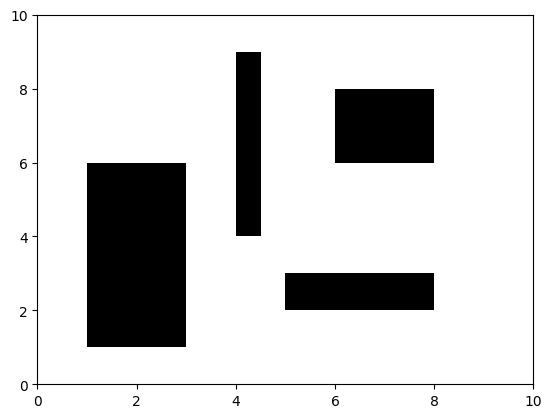

In [5]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))

plt.show()

# Primitive Functions

## Colisiones de puntos

In [6]:
# CIRCLE/RECTANGLE
def circleRect(cx,cy,radius, rx, ry, rw, rh):

  # temporary variables to set edges for testing
  testX = cx;
  testY = cy;

  # which edge is closest?
  if (cx < rx):
    testX = rx      # test left edge
  elif (cx > rx+rw):
    testX = rx+rw   # right edge
  if (cy < ry):
    testY = ry      # top edge
  elif (cy > ry+rh):
    testY = ry+rh   # bottom edge

  # get distance from closest edges
  distX = cx-testX
  distY = cy-testY
  distance = np.sqrt((distX*distX) + (distY*distY))

  # if the distance is less than the radius, collision!
  if (distance <= radius):
    return True

  return False

def sampleFree(x,y,r):

  if x+r > limsup_X or x-r < liminf_X:
    return False

  if y+r > limsup_Y or y-r < liminf_Y:
    return False

  for rec in obstacles:
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    if circleRect(x,y,r, rx, ry, rw, rh) == True:
      return False

  return True

In [7]:
sampleFree(0.3, 0.3, 1)

False

## Colisiones de aristas

In [8]:
def segmento_colisiona_con_rectangulo(x1, y1, x2, y2, rx, ry, rw, rh):
    # Comprobar si alguno de los puntos está dentro del rectángulo
    if (rx <= x1 <= rx + rw and ry <= y1 <= ry + rh) or (rx <= x2 <= rx + rw and ry <= y2 <= ry + rh):
        return True

    # Comprobar si alguno de los puntos del rectángulo está dentro del segmento de línea
    if (x1 <= rx <= x2 and y1 <= ry <= y2) or (x1 <= rx + rw <= x2 and y1 <= ry <= y2):
        return True

    # Comprobar si hay una intersección entre el segmento de línea y alguno de los lados del rectángulo
    if segmento_intersecta_con_linea(x1, y1, x2, y2, rx, ry, rx + rw, ry):  # Lado superior del rectángulo
        return True
    if segmento_intersecta_con_linea(x1, y1, x2, y2, rx + rw, ry, rx + rw, ry + rh):  # Lado derecho del rectángulo
        return True
    if segmento_intersecta_con_linea(x1, y1, x2, y2, rx, ry + rh, rx + rw, ry + rh):  # Lado inferior del rectángulo
        return True
    if segmento_intersecta_con_linea(x1, y1, x2, y2, rx, ry, rx, ry + rh):  # Lado izquierdo del rectángulo
        return True

    return False


def segmento_intersecta_con_linea(x1, y1, x2, y2, x3, y3, x4, y4):
    # Verificar si las líneas se intersectan utilizando la fórmula de la intersección de dos líneas
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return False  # Las líneas son paralelas o coincidentes

    # Calcular las coordenadas de intersección
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

    # Verificar si el punto de intersección está dentro de los segmentos de línea
    if min(x1, x2) <= intersect_x <= max(x1, x2) and min(y1, y2) <= intersect_y <= max(y1, y2) and \
            min(x3, x4) <= intersect_x <= max(x3, x4) and min(y3, y4) <= intersect_y <= max(y3, y4):
        return True

    return False

def collisionFree(x1, y1, x2, y2, r):
  for rec in obstacles:
    #Parametros del obstaculo (rectangulo)
    rx = rec.pos[0]
    ry = rec.pos[1]
    rw = rec.width
    rh = rec.height

    numSamples = 10

    for i in range(numSamples+1):
      xm = (x2-x1)*(i/numSamples)+x1
      ym = (y2-y1)*(i/numSamples)+y1
      #Si un circulo de la muestra no es libre de colision,
      #regresamos que la trayectoria no es posible
      if sampleFree(xm,ym,r) == False:
        return False


  return True

In [9]:
collisionFree(2,4,2,7,0.25)

False

## Near Function

In [10]:
def Near(V, x, y, r):
  B = []

  for v in V:
    v = np.array([v.locationX, v.locationY]) #np.array(v)
    u = np.array([x, y])
    if np.linalg.norm(u - v) < r:
      B.append(v)
  return B

## Nearest Function

In [11]:
def Nearest(V,x,y):
  vmincoord = np.array([np.inf,np.inf])
  vmin = treeNode(vmincoord[0], vmincoord[1])
  for v in V:
    v_coords = np.array([v.locationX, v.locationY])
    u = np.array([x, y])
    if np.linalg.norm(u - v_coords) < np.linalg.norm(u - vmincoord):
      vmin = v
      vmincoord = v_coords

  return vmin

## Steer Function

In [12]:
def Steer(x1,y1,x2,y2,eta):
  magn = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

  dx = (x2 - x1)/ magn
  dy = (y2 - y1)/ magn

  z_x = x1 + eta*dx
  z_y = y1 + eta*dy

  z = np.array([z_x, z_y])
  return z

# RRT

In [13]:
class treeNode(): #definimos la estructura de arbol con nodos
    def __init__(self, locationX, locationY):
      self.locationX = locationX
      self.locationY = locationY
      self.children = []
      self.parent = None

In [14]:
def addChild(locationX, locationY, nearestNode): #operacion de agregarle un hijo al nodo actual
    nodeNovo = []
    #if(locationX == goalpos.locationX):
       # nearestNode.children.append(goalpos)
       # goalpos.parent = nearestNode
        #nodeNovo.append(goalpos)

    #else:
    newNode = treeNode(locationX, locationY)
    nearestNode.children.append(newNode)
    newNode.parent = nearestNode
    nodeNovo.append(newNode)

    return nodeNovo

In [15]:
def SampleApoint(radio): # tomamos un punto aleatorio y vemos que no colisione

    X = np.random.uniform(liminf_X,limsup_X) #coordenadas del punto aleatorio
    Y = np.random.uniform(liminf_Y,limsup_Y)
    point = np.array([X, Y])

    if sampleFree(X, Y, radio) == False: # hasta que el punto no colisione con un objeto, lo seguimos generando
        while sampleFree(X, Y, radio) == False :
          X = np.random.uniform(liminf_X,limsup_X)
          Y = np.random.uniform(liminf_Y,limsup_Y)
          point = np.array([X, Y])


    return point

In [16]:
def goalfound(point, goalpos): # si el punto actual se encuentra muy cerca de el punto objetivo
    rho = 0.25
    goal_coord = np.array([goalpos.locationX, goalpos.locationY])
    if np.linalg.norm(goal_coord - point) <= rho:
        return True
    else:
        return False


In [17]:
def RRT( goal, numItrs, stepSize, NodeList, radio):

    #goal_coord = np.array([goal.locationX, goal.locationY])
    #print(goal_coord)

    for i in range(numItrs):
        x_rand = SampleApoint(radio) #punto aleatorio sin colisiones
        #print(x_rand)
        nearest_node = Nearest(NodeList, x_rand[0],x_rand[1])#vemos cual nodo dentro del arbol es el mas cercano al punto

        x_nearest = np.array([nearest_node.locationX, nearest_node.locationY])# nodo mas cercano
        #print(x_nearest)

        x_new = Steer(x_nearest[0], x_nearest[1], x_rand[0], x_rand[1], stepSize) #avanzamos en la direccion del punto aleatorio

        if collisionFree(x_nearest[0],x_nearest[1], x_new[0],x_new[1], radio): #si no hay colision en la trayectoria
            NodeList = NodeList + addChild(x_new[0], x_new[1], nearest_node) #agregamos el nuevo punto a la lista de nodos
            #print(len(NodeList))

            #if goalfound(x_new, goal):
                #NodeList = NodeList + addChild(goal_coord[0], goal_coord[1], nearest_node)
                #print("goal found ")
                #break

    closestGoal = Nearest(NodeList, goal.locationX, goal.locationY) #nodo mas cercano a la solucion

    return NodeList, closestGoal

In [18]:
def Fathers(Nodo): #funcion para ver el camino desde la raiz hasta la meta obtenida
  currentNode = Nodo
  Sucesion = []

  while currentNode.parent != None:
    Sucesion.append(currentNode)
    currentNode = currentNode.parent

  Sucesion.append(currentNode)

  #Sucesion.reverse()

  #for n in Sucesion:
    #print(n.currentpos[0])
    #print(n.currentpos[1])
    #print(n.currentpos[2])
    #print()

  return Sucesion

# Implementacion 1

In [19]:
startpos = treeNode(1,8)
NodeList = [startpos]

#print(NodeList[0].locationX)
#print(startpos.locationX)

radio = 0.25
goalpos = treeNode(8,1)
numItrs = 1000
stepSize =  0.5

Arbol, goalclose = RRT(goalpos, numItrs, stepSize, NodeList, radio)

Padres = Fathers(goalclose)

print(len(Padres))

#for v in Arbol :
  #print(v.locationX)


30


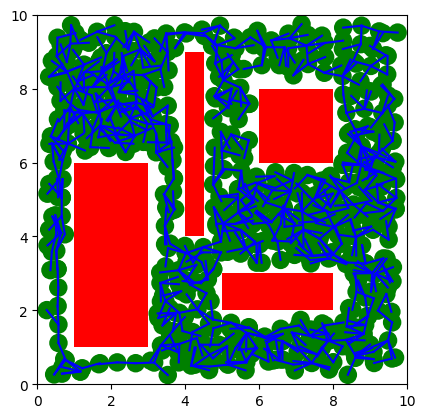

In [20]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


circle_patch = Circle((1, 8), 0.25, facecolor='blue')
ax.add_patch(circle_patch)

# Plotear los vértices
for v in Arbol:
    #print(v)
    #x, y = v
    x = v.locationX
    y = v.locationY
    circle_patch = Circle((x, y), 0.25, facecolor='green')
    ax.add_patch(circle_patch)
    #plt.plot(x, y, 'ro', markersize=10)  # 'ro' representa círculos rojos

# Plotear las aristas
i=0
for v in Arbol:
    print(i, end=' \r')
    x1 = v.locationX
    y1 = v.locationY
    for son in v.children:
      x2 = son.locationX
      y2 = son.locationY
      plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules

    i+=1

ax.set_aspect('equal')

plt.show()

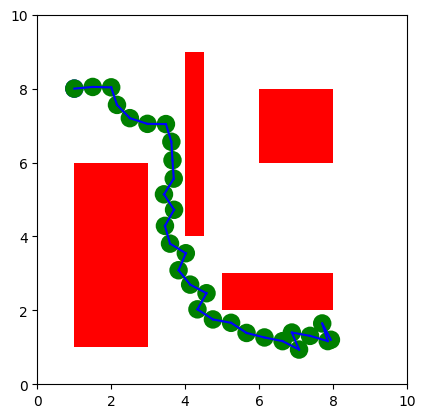

In [21]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


circle_patch = Circle((1, 8), 0.25, facecolor='blue')
ax.add_patch(circle_patch)


for v in Padres:
    #print(v)
    #x, y = v
    x = v.locationX
    y = v.locationY
    circle_patch = Circle((x, y), 0.25, facecolor='green')
    ax.add_patch(circle_patch)
    #plt.plot(x, y, 'ro', markersize=10)  # 'ro' representa círculos rojos

# Plotear las aristas
i=0
for v in Padres:
    print(i, end=' \r')
    if v.parent != None:
        x1 = v.locationX
        y1 = v.locationY

        padre = v.parent
        x2 = padre.locationX
        y2 = padre.locationY

        plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
        i+=1



ax.set_aspect('equal')

plt.show()

# Implementacion 2

In [22]:
obstacles = []
wt = 0.25/2

liminf_X = 0 
limsup_X = 8

liminf_Y = 0
limsup_Y = 8

#Paredes del laberinto
obstacles.append(Obstacle((2-wt,0), 0.25, 2 + wt))
obstacles.append(Obstacle((2+wt, 2-wt), 2, 0.25))

obstacles.append(Obstacle((0, 4-wt), 4-wt, 0.25))
obstacles.append(Obstacle((4-wt, 4-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((2-wt, 6-wt), 2, 0.25))

obstacles.append(Obstacle((6-wt, 6-wt), 0.25, 2 + 2*wt))

obstacles.append(Obstacle((6-wt, 2-wt), 0.25, 2 + 2*wt))
obstacles.append(Obstacle((6+wt, 4-wt), 2-wt, 0.25))

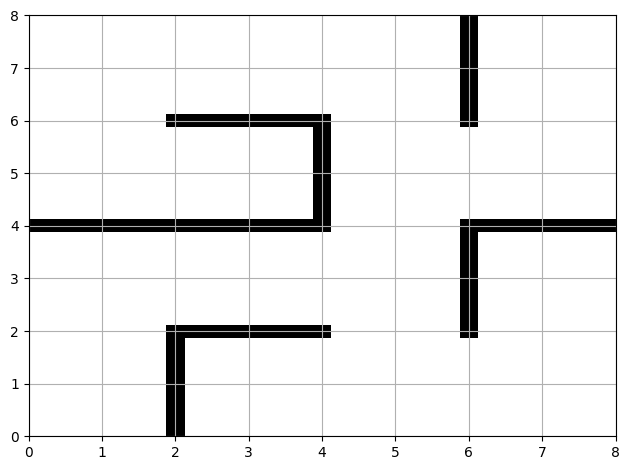

In [23]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))

plt.grid()
plt.tight_layout()
plt.show()

In [24]:
startpos = treeNode(0.5,0.5)
NodeList = [startpos]

#print(NodeList[0].locationX)
#print(startpos.locationX)

radio = 0.25
goalpos = treeNode(3,5)
numItrs = 1000
stepSize =  0.5

Arbol, goalclose = RRT(goalpos, numItrs, stepSize, NodeList, radio)

Padres = Fathers(goalclose)

print(len(Padres))

#for v in Arbol :
  #print(v.locationX)


38


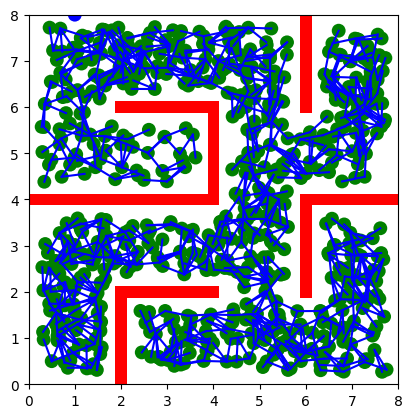

In [25]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


circle_patch = Circle((1, 8), 0.15, facecolor='blue')
ax.add_patch(circle_patch)

# Plotear los vértices
for v in Arbol:
    #print(v)
    #x, y = v
    x = v.locationX
    y = v.locationY
    circle_patch = Circle((x, y), 0.15, facecolor='green')
    ax.add_patch(circle_patch)
    #plt.plot(x, y, 'ro', markersize=10)  # 'ro' representa círculos rojos

# Plotear las aristas
i=0
for v in Arbol:
    print(i, end=' \r')
    x1 = v.locationX
    y1 = v.locationY
    for son in v.children:
      x2 = son.locationX
      y2 = son.locationY
      plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules

    i+=1

ax.set_aspect('equal')

plt.show()

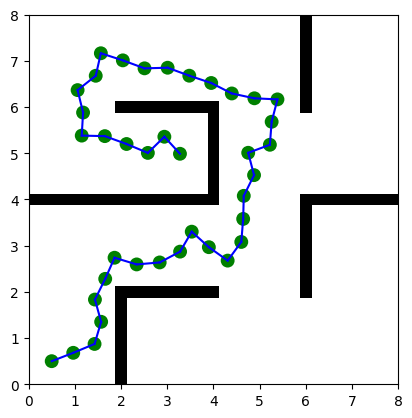

In [26]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)


for v in Padres:
    #print(v)
    #x, y = v
    x = v.locationX
    y = v.locationY
    circle_patch = Circle((x, y), 0.15, facecolor='green')
    ax.add_patch(circle_patch)
    #plt.plot(x, y, 'ro', markersize=10)  # 'ro' representa círculos rojos

# Plotear las aristas
i=0
for v in Padres:
    print(i, end=' \r')
    if v.parent != None:
        x1 = v.locationX
        y1 = v.locationY

        padre = v.parent
        x2 = padre.locationX
        y2 = padre.locationY

        plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
        i+=1



ax.set_aspect('equal')

plt.show()

# Leer Puntos Comunes

In [27]:
# Nombre del archivo
nombre_archivo = 'initialPoints.txt' # leer puntos

# Lista de listas para almacenar los puntos leídos
listas_leidas = []

# Lista temporal para almacenar los puntos de cada lista
lista_temporal = []

# Leer las listas desde el archivo de texto
with open(nombre_archivo, 'r') as archivo:
    for linea in archivo:
        linea = linea.strip()
        if linea == '':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
        else:
            punto = tuple(map(float, linea.split(',')))
            if len(punto) == 2:
                lista_temporal.append(punto)

# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
for i, lista in enumerate(listas_leidas, 1):
    print(f'Lista {i} leída:', lista)
    #print(len(lista))
    #print()


Lista 1 leída: [(1.0523528875907853, 0.7584937909327754), (1.290161260539999, 0.8092814147159355), (0.8879130214701891, 0.5838274883938508), (0.8882697027444693, 0.940608293702951), (0.30339329774788926, 0.27148989127888457), (0.42633948511864705, 0.8293251991998218), (0.9083913515346536, 1.8410183582622608), (0.8057454855155466, 0.4025144811186403), (0.2631950758788897, 1.6058266358715272), (0.980699221447207, 0.9633489784008784)]
Lista 2 leída: [(3.6369764502236306, 0.6943309572331877), (2.611694808682101, 1.3794497623632076), (2.9652809170187093, 0.9501377164141374), (3.8135224574453748, 1.4668032964071702), (2.4369012148715035, 1.1942647401151159), (2.5399439898383758, 1.0328170899136813), (2.684754794091364, 0.43174480525582726), (3.9703615562660213, 0.7461824530685979), (3.7737552219186323, 0.4400390761263355), (3.4399752923183775, 1.0835457968962319)]
Lista 3 leída: [(4.659728389317476, 0.6601783651363076), (4.150655568098098, 1.236406474039632), (4.7079362390404, 0.873512567932

In [28]:
for i in range(len(listas_leidas)): #ver puntos de cada seccion / 16 
    for j in range(len(listas_leidas[i])):
        print(listas_leidas[i][j])
    print()

(1.0523528875907853, 0.7584937909327754)
(1.290161260539999, 0.8092814147159355)
(0.8879130214701891, 0.5838274883938508)
(0.8882697027444693, 0.940608293702951)
(0.30339329774788926, 0.27148989127888457)
(0.42633948511864705, 0.8293251991998218)
(0.9083913515346536, 1.8410183582622608)
(0.8057454855155466, 0.4025144811186403)
(0.2631950758788897, 1.6058266358715272)
(0.980699221447207, 0.9633489784008784)

(3.6369764502236306, 0.6943309572331877)
(2.611694808682101, 1.3794497623632076)
(2.9652809170187093, 0.9501377164141374)
(3.8135224574453748, 1.4668032964071702)
(2.4369012148715035, 1.1942647401151159)
(2.5399439898383758, 1.0328170899136813)
(2.684754794091364, 0.43174480525582726)
(3.9703615562660213, 0.7461824530685979)
(3.7737552219186323, 0.4400390761263355)
(3.4399752923183775, 1.0835457968962319)

(4.659728389317476, 0.6601783651363076)
(4.150655568098098, 1.236406474039632)
(4.7079362390404, 0.8735125679326727)
(4.538975805097362, 1.2686716753789031)
(4.606981196703051, 1.

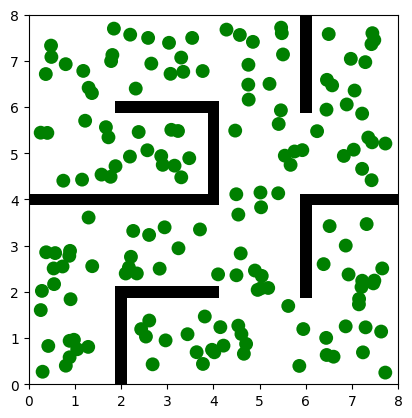

In [29]:
fig, ax = plt.subplots() #plotear puntos comunes
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)
# Plotear las aristas
i=0
for i in range(len(listas_leidas)):
    for j in range(len(listas_leidas[i])):
        x = listas_leidas[i][j][0]
        y = listas_leidas[i][j][1]
        circle_patch = Circle((x,y), 0.15, facecolor = 'green')
        ax.add_patch(circle_patch)
    


ax.set_aspect('equal')

plt.show()

# Generar Ptos Destino

In [30]:
def RandPointInRegion(radio, liminf_X, limsup_X, liminf_Y, limsup_Y): #genera puntos aleatorios en la region dada

    X = np.random.uniform(liminf_X,limsup_X)
    Y = np.random.uniform(liminf_Y,limsup_Y)
    point = np.array([X, Y])

    if sampleFree(X, Y, radio) == False:
        while sampleFree(X, Y, radio) == False :
          X = np.random.uniform(liminf_X,limsup_X)
          Y = np.random.uniform(liminf_Y,limsup_Y)
          point = np.array([X, Y])


    return point

In [31]:
def GeneratePointsInRegion(limSupx, limSupy): #regresa una lista de 15 puntos, donde 
    #hay un punto por region
    puntosreg = [] #Un punto por region
    for i in range(4):
        for j in range(4):
            xsup = 2*(i+1)
            xinf = 2*i

            ysup = 2*(j+1)
            yinf = 2*j

            
            goalpos = RandPointInRegion(radio, xinf, xsup, yinf, ysup)
            puntosreg.append(goalpos)
            #print(goalpos)
            if (xsup == limSupx and ysup == limSupy): #eliminamos la region actual
                  #print(goalpos)
                  #print(puntosreg)
                  puntosreg.pop()
    return puntosreg

# Generar Caminos 2horas

In [32]:
radio = 0.25 
n = 0
secciones = []
for i in range(len(listas_leidas)): #ver puntos de cada seccion / 16 secciones
    PtsInRegionX = []
    for j in range(len(listas_leidas[i])): # ver cada punto de la seccion / 10 puntos
        
        #print(listas_leidas[i][j][1])

        startpos = treeNode(listas_leidas[i][j][0], listas_leidas[i][j][1])
        NodeList = [startpos]
        print("Intervalo ", (i%4)*2 + 2, " ", (int(i/4))*2 + 2)
        
        #DestinyPoints = GeneratePointsInRegion(4, 2)
        
        Caminos = [] #generamos los 15 caminos de un punto
        for k in range(15):
            n += 1
            DestinyPoints = GeneratePointsInRegion((i%4)*2 + 2, (int(i/4))*2 + 2)
            goalpos = DestinyPoints[k]
            goalpos = treeNode(goalpos[0], goalpos[1])

            numItrs = 1000
            stepSize =  0.5

            Arbol, goalclose = RRT(goalpos, numItrs, stepSize, NodeList, radio)

            Padres = Fathers(goalclose)
            Caminos.append(Padres) #guardamos los caminos para los 15 puntos desde el punto inicial
            #print(goalpos)
            #print(startpos.locationX)
        PtsInRegionX.append(Caminos)
        

    secciones.append(PtsInRegionX)
    print("seccion terminada ")
    print()

print(n)

Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
Intervalo  2   2
seccion terminada 

Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
Intervalo  4   2
seccion terminada 

Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
Intervalo  6   2
seccion terminada 

Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
Intervalo  8   2
seccion terminada 

Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
Intervalo  2   4
seccion terminada 

Intervalo  4   4
Intervalo  4   4
Intervalo  4   4

In [33]:
print(len(secciones))

16


# CHECK RESULTS

In [34]:
print(len(secciones), "regiones")
print(len(secciones[1]), "puntos iniciales")
print(len(secciones[1][1]), "puntos destino")
print(len(secciones[0][0][13]), "nodos en el camino")
print((secciones[0][0][14][0].locationX))
print((secciones[0][0][14][0].locationY))


print()

print(len(listas_leidas))
print(len(listas_leidas[0]))

16 regiones
10 puntos iniciales
15 puntos destino
21 nodos en el camino
6.478970891408253
6.636591669924794

16
10


# Escribir en txt los resultados

In [35]:
# Nombre del archivo
nombre_archivo = 'Listas2.txt'
# Escribir las listas en el archivo de texto
with open(nombre_archivo, 'w') as archivo:
    for i in range(len(listas_leidas)): #ver puntos de cada region / 16 regiones
        for j in range(len(listas_leidas[i])): # 10 puntos de partida por region
            for k in range(15): #15 caminos de cada punto
                for nodo in secciones[i][j][k]: #recorremos cada nodo del camino
                    X = nodo.locationX
                    Y = nodo.locationY

                    archivo.write(f'{X},{Y}')
                    archivo.write(' ')

                archivo.write('\n') 
                
            archivo.write('\n')    

        archivo.write('\n')        
        archivo.write('\n')


# Leer TXT

In [33]:
# Nombre del archivo
nombre_archivo = 'Listas2.txt'

# Lista de listas para almacenar los caminos leídos
listas_leidas = []

# Lista temporal para almacenar los puntos de cada lista
lista_temporal = []
space = 0
indexRow = 0
j = 1
# Leer las listas desde el archivo de texto
with open(nombre_archivo, 'r') as archivo:
    for linea in archivo:
        #linea = linea.strip()
        indexRow += 1
        if j == indexRow:
            for word in linea.split():
                #print(word)
                punto = tuple(map(float, word.split(',')))
                if len(punto) == 2:
                    #print(indexRow)
                    lista_temporal.append(punto)

        elif linea != '\n':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
            j = indexRow
            for word in linea.split():
                #print(word)
                punto = tuple(map(float, word.split(',')))
                if len(punto) == 2:
                    #print(indexRow)
                    lista_temporal.append(punto)

        elif linea == '\n':
            if lista_temporal:
                listas_leidas.append(lista_temporal)
                lista_temporal = []
                  


# Asegurarse de agregar la última lista temporal a la lista de listas
if lista_temporal:
    listas_leidas.append(lista_temporal)

# Imprimir las listas leídas
print(len(listas_leidas))
#for i, lista in enumerate(listas_leidas, 1):
    #print(f'Lista {i} leída:', lista)

for k in range(len(listas_leidas)): #invertir para que empiece desde el pto inicial 
    listas_leidas[k].reverse()

2400


# Generar sets de Train y Test

In [34]:
print(len(listas_leidas))
min = np.inf
max = -np.inf
mayores20 = 0
mayores10 = 0
for i in range(len(listas_leidas)): #recorremos todos los caminos
    if len(listas_leidas[i]) > max: #vemos que camino es mas largo
        max = len(listas_leidas[i])
    if len(listas_leidas[i]) < min:
        min = len(listas_leidas[i])

    if len(listas_leidas[i]) >= 20:
        mayores20 +=1 
    if len(listas_leidas[i]) >= 10:
        mayores10 +=1 
    #print(len(listas_leidas[i]))
    '''''
print(max)
print(min)
print(mayores20)
print(mayores10)
print(listas_leidas[0])
print(listas_leidas[1])
print(listas_leidas[0][0][0])
Arbol'''
M = len(listas_leidas)
#print(M)

NTrain = int(M * (1.0))
Ncontrol = int(M*(0.0))
Ntest = int(M*(0.05))


#print(NTrain)
#print(Ncontrol)
#print(Ntest)

TrainSet = []
ControlSet = []
TestSet = []

for i in range(NTrain):
    TrainSet.append(listas_leidas[i])
    #print(i)
print(len(TrainSet))


for i in range(NTrain, NTrain + Ncontrol):
    ControlSet.append(listas_leidas[i])
    #print(i)

print(len(ControlSet))

for i in range(Ntest):
    idx = random.randint(0,len(listas_leidas) - 1)
    TestSet.append(listas_leidas[idx])
#for i in range(NTrain + Ncontrol, NTrain + Ncontrol + Ntest):
    #TestSet.append(listas_leidas[i])
    #print(i)

print(len(TestSet))

suma = len(TestSet) + len(ControlSet) + len(TrainSet)
print(suma)

2400
2400
0
120
2520


# Imprimir lista leída

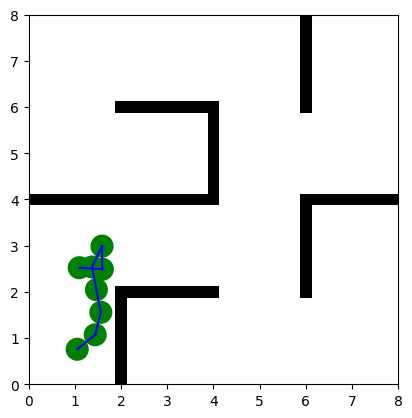

In [35]:
fig, ax = plt.subplots() #caminos desde un punto
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)

for k in range(1):
    for v in listas_leidas[k]:
        x = v[0]
        y = v[1]
        circle_patch = Circle((x, y), 0.25, facecolor='green')
        ax.add_patch(circle_patch)

    i = 0
    for j in range(len(listas_leidas[k])):
        print(i, end=' \r')
        if j != 0:
            x1 = listas_leidas[k][j][0]
            y1 = listas_leidas[k][j][1]

            padre = listas_leidas[k][j - 1]
            x2 = padre[0]
            y2 = padre[1]

            plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
            i+=1

ax.set_aspect('equal')

plt.show()

# Generar conjunto de entrenamiento

In [36]:
X_train = []
Y_train = []
for k in range(len(TrainSet)):
    n = len(TrainSet[k]) - 1
    q_goal = TrainSet[k][n]
    for t in range(len(TrainSet[k])):
        #n = len(TrainSet[k]) - 1
        tupla = []
        tupla2 = []
        if t != n:
            q_t = TrainSet[k][t]
            q_t_plus1 = TrainSet[k][t + 1]
            tupla.append(q_t[0])
            tupla.append(q_t[1])
            tupla.append(q_goal[0])
            tupla.append(q_goal[1])

            X_train.append(tupla)

            tupla2.append(q_t_plus1[0])
            tupla2.append(q_t_plus1[1])

            Y_train.append(tupla2)


print(len(TrainSet[0]))
print(len(X_train))
print(len(Y_train))

print(X_train[0])
print(Y_train[0])
print(X_train[1])
print(Y_train[1])
print(X_train[9])
print(Y_train[9])
print()
print(X_train[10])
print(Y_train[10])

8
44481
44481
[1.0523528875907853, 0.7584937909327754, 1.09692049657608, 2.5229385258418975]
[1.4421237229648287, 1.0716689749621304]
[1.4421237229648287, 1.0716689749621304, 1.09692049657608, 2.5229385258418975]
[1.562923126177673, 1.5568570871242284]
[1.1715955519863868, 1.5638906183053543, 1.490324811255135, 4.649129473488166]
[1.5173265578140156, 1.9250970296679104]

[1.5173265578140156, 1.9250970296679104, 1.490324811255135, 4.649129473488166]
[1.597389403309252, 2.418645346219802]


In [92]:
X_control = []
Y_control = []
for k in range(len(ControlSet)):
    n = len(ControlSet[k]) - 1
    q_goal = ControlSet[k][n]
    for t in range(len(ControlSet[k] ) ):
        #n = len(TrainSet[k]) - 1
        tupla = []
        tupla2 = []
        if t != n:
            q_t = ControlSet[k][t]
            q_t_plus1 = ControlSet[k][t + 1]
            tupla.append(q_t[0])
            tupla.append(q_t[1])
            tupla.append(q_goal[0])
            tupla.append(q_goal[1])

            X_control.append(tupla)

            tupla2.append(q_t_plus1[0])
            tupla2.append(q_t_plus1[1])

            Y_control.append(tupla2)


In [37]:
X_test = []
Y_test = []
for k in range(len(TestSet) ):
    n = len(TestSet[k]) - 1
    q_goal = TestSet[k][n]
    for t in range(len(TestSet[k] ) ):
        #n = len(TrainSet[k]) - 1
        tupla = []
        tupla2 = []
        if t != n:
            q_t = TestSet[k][t]
            q_t_plus1 = TestSet[k][t + 1]
            tupla.append(q_t[0])
            tupla.append(q_t[1])
            tupla.append(q_goal[0])
            tupla.append(q_goal[1])

            X_test.append(tupla)

            tupla2.append(q_t_plus1[0])
            tupla2.append(q_t_plus1[1])

            Y_test.append(tupla2)


In [38]:

for k in range(16):
    n = len(TestSet[k]) - 1 
    print(TestSet[k][0]) # punto inicial en una region
    print(TestSet[k][n]) #punto destino
    
    print()

(7.424001989448059, 4.4166953330467695)
(3.7493919854636983, 1.0780150663255292)

(0.2631950758788897, 1.6058266358715272)
(2.7781742446593447, 0.358497337663628)

(7.317020416315542, 3.467434382184379)
(4.126676422639023, 0.8602909186016331)

(7.056343221596971, 6.357930933230966)
(7.6586442402194805, 2.783649075946885)

(5.756067322449473, 5.03888497031389)
(1.517780776872957, 1.8115645804527007)

(4.1017918606559505, 2.3793289832778943)
(1.77772950526254, 4.612524288995095)

(3.089058603541095, 5.50792587972213)
(4.13536485296083, 1.4853384997464611)

(0.8882697027444693, 0.940608293702951)
(2.7241847146509546, 7.365119572765357)

(7.150044937374905, 1.7299796746523595)
(6.427780919276255, 5.718231137612943)

(2.3191326707877806, 6.400255223572279)
(7.115129151133628, 1.043058838629268)

(6.822894073512296, 4.942574653547464)
(4.146590792674211, 2.669688146319964)

(2.656127451566036, 6.94107144588964)
(1.752973825151989, 2.424514430170934)

(4.659728389317476, 0.6601783651363076)
(

In [39]:

for k in range(16):
    n = len(TrainSet[k]) - 1 
    print(TrainSet[k][0]) # punto inicial en una region
    print(TrainSet[k][n]) #punto destino
    
    print()

(1.0523528875907853, 0.7584937909327754)
(1.09692049657608, 2.5229385258418975)

(1.0523528875907853, 0.7584937909327754)
(1.490324811255135, 4.649129473488166)

(1.0523528875907853, 0.7584937909327754)
(0.5313033177078178, 6.761363394707743)

(1.0523528875907853, 0.7584937909327754)
(2.7533337391511554, 0.5544266699915632)

(1.0523528875907853, 0.7584937909327754)
(3.3461024361579637, 3.2195861887051644)

(1.0523528875907853, 0.7584937909327754)
(1.8701450233584598, 5.546496970452376)

(1.0523528875907853, 0.7584937909327754)
(2.8328646421035493, 7.315667575677117)

(1.0523528875907853, 0.7584937909327754)
(5.112294757362326, 0.8790393798062569)

(1.0523528875907853, 0.7584937909327754)
(4.7630384457668375, 2.9837140298819196)

(1.0523528875907853, 0.7584937909327754)
(5.055479144908873, 6.044720607130153)

(1.0523528875907853, 0.7584937909327754)
(5.500445738787884, 6.070234895119528)

(1.0523528875907853, 0.7584937909327754)
(6.518110663324076, 1.313332472529672)

(1.052352887590785

# Machine Learning Sklearn

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier #for classification problems
from sklearn.neural_network import MLPRegressor  #for regression problems
import sklearn

In [37]:
clf = MLPRegressor( hidden_layer_sizes=(128,64, 32),solver="lbfgs",max_iter = 4000 ,alpha=0)
clf.fit(X_train,Y_train)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0, hidden_layer_sizes=(128, 64, 32), max_iter=4000,
             solver='lbfgs')

In [38]:
# Supongamos que tienes una nueva entrada en la forma (q_t, q_goal)
new_input = [[1.0, 2.0, 3.0, 4.0]]  # Ejemplo de nueva entrada

# Realizar la predicción utilizando el modelo entrenado
predicted_q_next = clf.predict(new_input)

# Imprimir el resultado de la predicción
print(predicted_q_next[0][0])

1.1830333369175967


In [39]:
verticesPath = []
inicio = [3, 5]
goal = [7, 3]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
    qnext = clf.predict(qt)
    qt = [[qnext[0][0], qnext[0][1], goal[0], goal[1]]]
    verticesPath.append([qnext[0][0],qnext[0][1]])

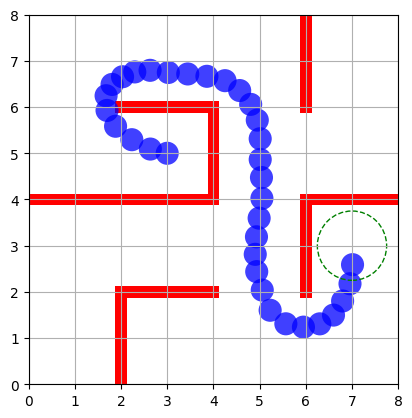

In [40]:
radius = 0.25
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

# Evaluar puntos de conjunto de prueba

In [41]:
pn = clf.predict(X_test)
print(len(X_test))
print(X_test[0])
print(X_test[0][1])
print(X_test[1])

NameError: name 'X_test' is not defined

In [43]:
print(type(pn[0]))
InitialNode = np.array([X_test[0][0],X_test[0][1]]) 
print(InitialNode)

<class 'numpy.ndarray'>
[7.42122146 7.36228158]


In [96]:
print(pn)
print(len(pn))

CaminosTest = []

CurrDestX = X_test[0][2]
CurrDestY = X_test[0][3]

CurrCamino = []

InitialNode = np.array([X_test[0][0],X_test[0][1]])
CurrCamino.append(InitialNode) 

for k in range(len(pn)): #checamos cada nodo previo de el conjunto de nuevos nodos q_tplus1
    #if itr == 0:
     # InitialNode = np.array([X_test[k][0],X_test[k][1]])
      #CurrCamino.append(InitialNode)  
    
    if X_test[k][2] == CurrDestX and X_test[k][3] == CurrDestY: #si tiene el mismo destino lo guardamos  en el camino 
        CurrCamino.append(pn[k]) #actual
        #k += 1
    else:
        CaminosTest.append(CurrCamino)
        CurrDestX = X_test[k][2]
        CurrDestY = X_test[k][3]

        CurrCamino = []

        InitialNode = np.array([X_test[k][0],X_test[k][1]])
        CurrCamino.append(InitialNode)

        CurrCamino.append(pn[k])

CaminosTest.append(CurrCamino)

print(len(X_test))
print(len(CaminosTest))



NameError: name 'pn' is not defined

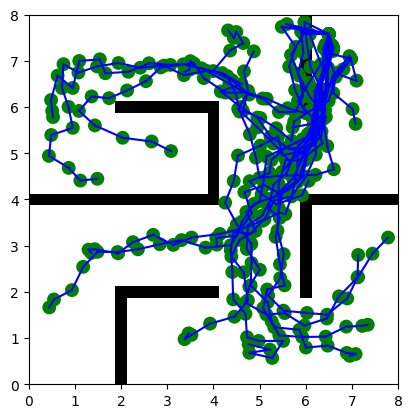

In [69]:
fig, ax = plt.subplots() #caminos desde un punto
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)

for k in range(100,120):
    for v in CaminosTest[k]:
        x = v[0]
        y = v[1]
        circle_patch = Circle((x, y), 0.25, facecolor='green')
        ax.add_patch(circle_patch)

    i = 0
    for j in range(len(CaminosTest[k])):
        print(i, end=' \r')
        if j != 0:
            x1 = CaminosTest[k][j][0]
            y1 = CaminosTest[k][j][1]

            padre = CaminosTest[k][j - 1]
            x2 = padre[0]
            y2 = padre[1]

            plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
            i+=1

ax.set_aspect('equal')

plt.show()

In [143]:
print(X_test[0])
print(X_test[1])

[4.85542924708383, 7.411530340910628, 1.666544593700449, 1.0801260622849829]
[4.849691942715223, 6.911563258655623, 1.666544593700449, 1.0801260622849829]


 100 pares, 3 redes con 4000 epocas
 1 skleanr
 2 tensorflow con dropout (25)
 3 tensfor sin dropout
 porcentaje de corridas de trayectorias sin colisionses (100)
 costo (distancia euclidiena entre nodos) extiosas
 tiempo de generar caminos (promedio y desviacion estandar) exitosas


# TensorFlow Regresion sin DropOut

In [42]:
import tensorflow as tf
import keras as keras
from keras.layers import PReLU
from keras import layers, losses, models
from keras.models import Model
import numpy as np

In [60]:
mlp = models.Sequential([
  layers.Dense(128, activation=PReLU()),
	#layers.Dropout(0.2),
  layers.Dense(64),
	layers.Activation(activation=PReLU()),
	#layers.Dropout(0.5),
  layers.Dense(32),
	#layers.Dropout(0.5),
	layers.Activation(activation=PReLU()),
  layers.Dense(2),
	#layers.Activation(activation=PReLU()),
])

In [61]:
epochs = 4000
obs_name = 'obs1'
vicinity = 'v1'
samples = 700
models_path = 'D:\PythonCode\Robotics\ModelPaths/' 
save_file_path = models_path+'trained_model_'+obs_name +'_'+vicinity+'_'+str(samples)+'_samples_'+str(epochs)+'_epochs.h5'

# Save the best model only wrt validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# Loss and Optimizer
mlp.compile(#loss=tf.keras.losses.MeanAbsoluteError(),
      loss=tf.keras.losses.MeanSquaredError(),
			optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
	 		#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#,metrics=['accuracy']
			)


# Training
history = mlp.fit(x = X_train ,
					y = Y_train,
					validation_data=(X_test, Y_test),
					batch_size=128,
					epochs=epochs,
					validation_split=0.05,
					verbose=2,
					callbacks=[model_checkpoint_callback]
)

Epoch 1/4000
348/348 - 2s - loss: 0.3411 - val_loss: 0.0819 - 2s/epoch - 6ms/step
Epoch 2/4000
348/348 - 1s - loss: 0.0763 - val_loss: 0.0767 - 721ms/epoch - 2ms/step
Epoch 3/4000
348/348 - 1s - loss: 0.0729 - val_loss: 0.0727 - 671ms/epoch - 2ms/step
Epoch 4/4000
348/348 - 1s - loss: 0.0707 - val_loss: 0.0704 - 646ms/epoch - 2ms/step
Epoch 5/4000
348/348 - 1s - loss: 0.0700 - val_loss: 0.0682 - 664ms/epoch - 2ms/step
Epoch 6/4000
348/348 - 1s - loss: 0.0683 - val_loss: 0.0653 - 642ms/epoch - 2ms/step
Epoch 7/4000
348/348 - 1s - loss: 0.0671 - val_loss: 0.0671 - 699ms/epoch - 2ms/step
Epoch 8/4000
348/348 - 1s - loss: 0.0665 - val_loss: 0.0643 - 781ms/epoch - 2ms/step
Epoch 9/4000
348/348 - 1s - loss: 0.0653 - val_loss: 0.0658 - 764ms/epoch - 2ms/step
Epoch 10/4000
348/348 - 1s - loss: 0.0647 - val_loss: 0.0607 - 820ms/epoch - 2ms/step
Epoch 11/4000
348/348 - 1s - loss: 0.0637 - val_loss: 0.0628 - 772ms/epoch - 2ms/step
Epoch 12/4000
348/348 - 1s - loss: 0.0632 - val_loss: 0.0597 - 848

In [62]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)

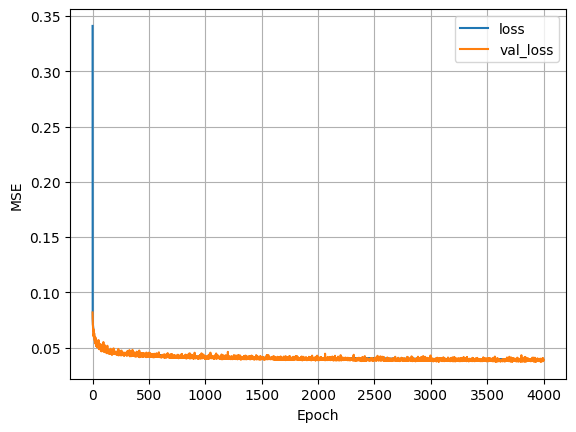

In [63]:
plot_loss(history)

In [43]:
model_path = 'D:/PythonCode/Robotics/ModelPaths/trained_model_obs1_v1_700_samples_4000_epochs.h5'
mlp = keras.models.load_model(model_path)

In [44]:
# Supongamos que tienes una nueva entrada en la forma (q_t, q_goal)
new_input = [[1.0, 2.0, 3.0, 4.0]]  # Ejemplo de nueva entrada

# Realizar la predicción utilizando el modelo entrenado
predicted_q_next = mlp.predict(new_input)

# Imprimir el resultado de la predicción
print(predicted_q_next)



1/1 [==============================] - 0s 352ms/step
[[1.1553619 2.2590952]]


In [65]:
verticesPath = []
inicio = [3, 5]
goal = [7, 3]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75:
    print(qt)
    qnext = mlp.predict(qt)
    qt = [[float(qnext[0][0]), float(qnext[0][1]), goal[0], goal[1]]]
    verticesPath.append([qnext[0][0],qnext[0][1]])

[[3, 5, 7, 3]]
1/1 [==============================] - 0s 92ms/step
[[2.4524734020233154, 4.830106258392334, 7, 3]]
1/1 [==============================] - 0s 35ms/step
[[1.966841697692871, 4.72511625289917, 7, 3]]
1/1 [==============================] - 0s 36ms/step
[[1.6154954433441162, 4.733476161956787, 7, 3]]
1/1 [==============================] - 0s 35ms/step
[[1.3824450969696045, 4.9153947830200195, 7, 3]]
1/1 [==============================] - 0s 35ms/step
[[1.2146940231323242, 5.181915760040283, 7, 3]]
1/1 [==============================] - 0s 39ms/step
[[1.1229336261749268, 5.435932636260986, 7, 3]]
1/1 [==============================] - 0s 35ms/step
[[1.1476421356201172, 5.591872692108154, 7, 3]]
1/1 [==============================] - 0s 36ms/step
[[1.2674612998962402, 5.758590221405029, 7, 3]]
1/1 [==============================] - 0s 37ms/step
[[1.312903642654419, 5.964229583740234, 7, 3]]
1/1 [==============================] - 0s 35ms/step
[[1.2219517230987549, 6.33172225952

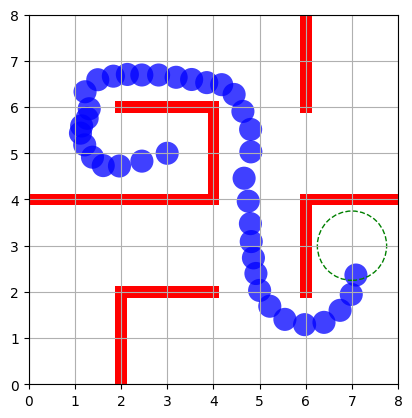

False


In [66]:
radius = 0.25
HitObs = False

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))
    if sampleFree(v[0], v[1], radius) == False:
       #print(v)
       HitObs = True

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()
print(HitObs)

# Tensor Fowe con DropOut

In [67]:
mlp2 = models.Sequential([
  layers.Dense(128, activation=PReLU()),
	layers.Dropout(0.25),
  layers.Dense(64),
	layers.Activation(activation=PReLU()),
	layers.Dropout(0.25),
  layers.Dense(32),
	layers.Dropout(0.25),
	layers.Activation(activation=PReLU()),
  layers.Dense(2),
	layers.Activation(activation=PReLU()),
])

In [68]:
epochs = 4000
obs_name = 'obs1'
vicinity = 'v1'
samples = 700
models_path = 'D:\PythonCode\Robotics\ModelPaths2/' 
save_file_path = models_path+'trained_model_'+obs_name +'_'+vicinity+'_'+str(samples)+'_samples_'+str(epochs)+'_epochs2.h5'

# Save the best model only wrt validation loss
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# Loss and Optimizer
mlp2.compile(#loss=tf.keras.losses.MeanAbsoluteError(),
      loss=tf.keras.losses.MeanSquaredError(),
			optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
	 		#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0005)
			#,metrics=['accuracy']
			)


# Training
history = mlp2.fit(x = X_train ,
					y = Y_train,
					validation_data=(X_test, Y_test),
					batch_size=128,
					epochs=epochs,
					validation_split=0.05,
					verbose=2,
					callbacks=[model_checkpoint_callback]
)

Epoch 1/4000
348/348 - 2s - loss: 1.8779 - val_loss: 0.2266 - 2s/epoch - 6ms/step
Epoch 2/4000
348/348 - 1s - loss: 0.8367 - val_loss: 0.2336 - 885ms/epoch - 3ms/step
Epoch 3/4000
348/348 - 1s - loss: 0.7000 - val_loss: 0.1935 - 982ms/epoch - 3ms/step
Epoch 4/4000
348/348 - 1s - loss: 0.6351 - val_loss: 0.1876 - 987ms/epoch - 3ms/step
Epoch 5/4000
348/348 - 1s - loss: 0.5850 - val_loss: 0.1673 - 1s/epoch - 3ms/step
Epoch 6/4000
348/348 - 1s - loss: 0.5405 - val_loss: 0.1060 - 978ms/epoch - 3ms/step
Epoch 7/4000
348/348 - 1s - loss: 0.5091 - val_loss: 0.1477 - 860ms/epoch - 2ms/step
Epoch 8/4000
348/348 - 1s - loss: 0.4645 - val_loss: 0.1462 - 853ms/epoch - 2ms/step
Epoch 9/4000
348/348 - 1s - loss: 0.4313 - val_loss: 0.1115 - 884ms/epoch - 3ms/step
Epoch 10/4000
348/348 - 1s - loss: 0.4044 - val_loss: 0.1148 - 885ms/epoch - 3ms/step
Epoch 11/4000
348/348 - 1s - loss: 0.3759 - val_loss: 0.0971 - 1s/epoch - 3ms/step
Epoch 12/4000
348/348 - 1s - loss: 0.3587 - val_loss: 0.1088 - 888ms/epo

In [69]:
model_path2 = 'D:/PythonCode/Robotics/ModelPaths2/trained_model_obs1_v1_700_samples_4000_epochs2.h5'
mlp2 = keras.models.load_model(model_path2)

In [70]:
# Supongamos que tienes una nueva entrada en la forma (q_t, q_goal)
new_input = [[1.0, 2.0, 3.0, 4.0]]  # Ejemplo de nueva entrada

# Realizar la predicción utilizando el modelo entrenado
predicted_q_next = mlp2.predict(new_input)

# Imprimir el resultado de la predicción
print(predicted_q_next)



1/1 [==============================] - 0s 103ms/step
[[1.3975341 2.359455 ]]


In [71]:
verticesPath = []
inicio = [3, 5]
goal = [7, 3]

qt = [[inicio[0], inicio[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])
i = 0
while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and i < 200:
    print(qt)
    qnext = mlp2.predict(qt)
    qt = [[float(qnext[0][0]), float(qnext[0][1]), goal[0], goal[1]]]
    verticesPath.append([qnext[0][0],qnext[0][1]])
    i+=1

[[3, 5, 7, 3]]
1/1 [==============================] - 0s 103ms/step
[[2.419334888458252, 5.150783538818359, 7, 3]]
1/1 [==============================] - 0s 36ms/step
[[2.061420440673828, 5.242204666137695, 7, 3]]
1/1 [==============================] - 0s 39ms/step
[[1.7109460830688477, 5.381744384765625, 7, 3]]
1/1 [==============================] - 0s 36ms/step
[[1.48823881149292, 5.612687110900879, 7, 3]]
1/1 [==============================] - 0s 36ms/step
[[1.3599834442138672, 5.844033718109131, 7, 3]]
1/1 [==============================] - 0s 38ms/step
[[1.3804528713226318, 6.277764320373535, 7, 3]]
1/1 [==============================] - 0s 40ms/step
[[1.4940481185913086, 6.654180526733398, 7, 3]]
1/1 [==============================] - 0s 34ms/step
[[1.7776925563812256, 6.889587879180908, 7, 3]]
1/1 [==============================] - 0s 34ms/step
[[2.2154979705810547, 7.032413482666016, 7, 3]]
1/1 [==============================] - 0s 35ms/step
[[2.6589646339416504, 7.105232238769

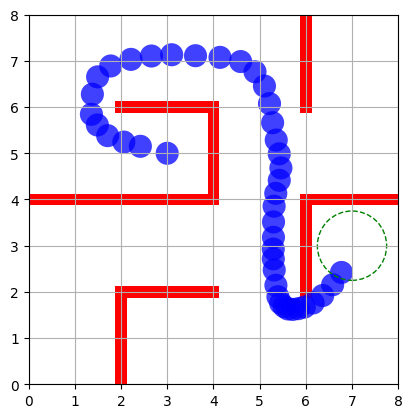

True


In [72]:
radius = 0.25
HitObs = False

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), radius, facecolor='blue', alpha = 0.75))
    if sampleFree(v[0], v[1], radius) == False:
       #print(v)
       HitObs = True

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()
print(HitObs)

# 100 puntos aleatorios de prueba 

In [42]:
# Leer los datos del archivo de texto
_100_pts = np.loadtxt('Puntos_aleatorios_Neurona.txt')

# Imprimir los arreglos leídos
print("Arreglos leídos del archivo:")
for arreglo in _100_pts:
    print(arreglo)

Arreglos leídos del archivo:
[0.52487734 0.74404224 5.80209241 4.4399534 ]
[7.07208366 1.42891251 0.67212556 0.59518626]
[5.86988382 4.58690591 4.33915045 7.12155994]
[1.11308728 0.82414198 3.356034   2.62791461]
[0.89811852 2.82971072 3.22546021 1.44259316]
[0.41975564 3.09936053 6.56694507 1.993346  ]
[0.41480476 7.31585381 2.54109136 4.40642506]
[5.41210812 5.10176324 4.37874955 4.59320382]
[0.41937678 2.63836201 2.72223078 4.93395264]
[0.77897214 0.83696132 4.2982497  6.81464969]
[6.30807009 4.71106308 4.25711603 0.76985741]
[6.78477974 1.74544338 2.2065893  6.9043654 ]
[0.40625173 2.2292443  7.09718204 5.20276405]
[4.85527483 3.83081403 0.57710047 0.48539144]
[5.04402371 1.20168348 6.76556132 7.58802184]
[7.23520134 5.75913352 6.94181338 6.39018322]
[4.41971426 7.25411222 6.66349378 4.85951616]
[1.75621813 4.89082966 0.549699   6.56199793]
[0.40770758 7.68203098 7.57224701 7.14575921]
[2.96974334 7.5866397  2.62048311 0.78488347]
[2.5243499  7.47075618 6.88347515 5.07880398]
[2.65

# SKlearn 100 pts

In [43]:
# Supongamos que tienes una nueva entrada en la forma (q_t, q_goal)
new_input = [[1.0, 2.0, 3.0, 4.0]]  # Ejemplo de nueva entrada

# Realizar la predicción utilizando el modelo entrenado
predicted_q_next = clf.predict(new_input)

# Imprimir el resultado de la predicción
print(predicted_q_next[0])

[1.18303334 2.36346315]


In [44]:
#print(pn)
#print(len(pn))
Tiempos = []

CaminosTest = []

CurrDestX = _100_pts[0][2]
CurrDestY = _100_pts[0][3]

CurrCamino = []
#GoalNode = np.array([_100_pts[0][2] ,_100_pts[0][3]])
#CurrCamino.append(InitialNode) 

#qt = [[InitialNode[0], InitialNode[1], GoalNode[0], GoalNode[1]]]

for i in range(len(_100_pts)): #checamos cada nodo previo de el conjunto de nuevos nodos q_tplus1
    #if itr == 0:
     # InitialNode = np.array([X_test[k][0],X_test[k][1]])
      #CurrCamino.append(InitialNode)
      start = time.time()

      qt = [[_100_pts[i][0], _100_pts[i][1], _100_pts[i][2], _100_pts[i][3]]]

      InitialNode = np.array([_100_pts[i][0],_100_pts[i][1]])
      GoalNode = np.array([_100_pts[i][2] ,_100_pts[i][3]])
      CurrCamino.append(InitialNode) 

      while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(GoalNode)) >= 0.75:
        qnext = clf.predict(qt)
        qt = [[qnext[0][0], qnext[0][1], GoalNode[0], GoalNode[1]]]
        CurrCamino.append([qnext[0][0],qnext[0][1]])
      
      CaminosTest.append(CurrCamino)

      end = time.time()
      Tiempos.append(end - start)

      CurrCamino = []

#print(len(_100_pts))
#print(len(CaminosTest))
#print(Tiempos)

In [45]:
print(len(CaminosTest))
print(CaminosTest[2])
#for k in range(len(CaminosTest)):
    #print(CaminosTest[k])

100
[array([5.86988382, 4.58690591]), [5.666217130809004, 4.879773477565374], [5.45710261004072, 5.187820795386761], [5.266570297754609, 5.531762434074226], [5.1383514723876145, 5.901218302400754], [4.993020157491751, 6.331577525024189], [4.780965089407509, 6.697867936641939]]


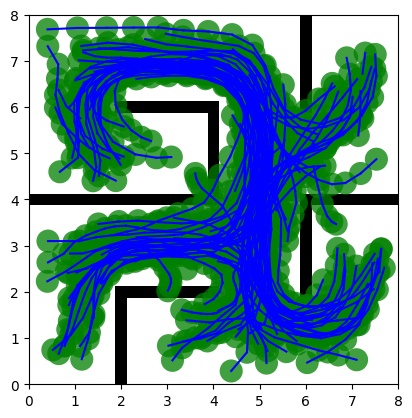

El numero de caminos sin colisión fue de  82


In [47]:
radius = 0.25

CaminosSinColl = []
TiemposSinColl = []


fig, ax = plt.subplots() #caminos desde un punto
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)
hitPos = False
for k in range(100):
    for v in CaminosTest[k]:
        ax.add_patch(Circle((v[0], v[1]), radius, facecolor='green', alpha = 0.75))
        if sampleFree(v[0], v[1], radius) == False: # si no es libre de colision entonces si pega
            hitPos = True
    if hitPos == False: #si no pega con un obstaculo
       CaminosSinColl.append(CaminosTest[k])
       TiemposSinColl.append(Tiempos[k])
    hitPos = False
        #print(k)
    i = 0
    for j in range(len(CaminosTest[k])):
        print(i, end=' \r')
        if j != 0:
            x1 = CaminosTest[k][j][0]
            y1 = CaminosTest[k][j][1]

            padre = CaminosTest[k][j - 1]
            x2 = padre[0]
            y2 = padre[1]

            plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
            i+=1
    

ax.set_aspect('equal')

plt.show()
print("El numero de caminos sin colisión fue de ", len(CaminosSinColl))
#print(len(TiemposSinColl))

In [48]:
np.linalg.norm(np.array(CaminosSinColl[0][1]) - np.array(CaminosSinColl[0][2]))
print(np.array(CaminosSinColl[0][1]))
print(TiemposSinColl)
sumatime = 0
for i in range(len(TiemposSinColl)):
    sumatime += TiemposSinColl[i]
meantime = sumatime/len(TiemposSinColl)

print("El tiempo promedio fue de ", meantime)

[0.91335657 1.06967494]
[0.0029745101928710938, 0.002997875213623047, 0.0, 0.0009996891021728516, 0.002004861831665039, 0.0009958744049072266, 0.0, 0.0030019283294677734, 0.002016305923461914, 0.0019440650939941406, 0.0010373592376708984, 0.0019989013671875, 0.0, 0.0009639263153076172, 0.0009999275207519531, 0.0030007362365722656, 0.0010006427764892578, 0.000988006591796875, 0.003033876419067383, 0.001993417739868164, 0.0, 0.0, 0.0030035972595214844, 0.002965688705444336, 0.0010008811950683594, 0.0009989738464355469, 0.0019998550415039062, 0.00203704833984375, 0.0029993057250976562, 0.001001119613647461, 0.0009992122650146484, 0.0010025501251220703, 0.0019681453704833984, 0.0010323524475097656, 0.002965688705444336, 0.0, 0.0, 0.0010001659393310547, 0.0030007362365722656, 0.00099945068359375, 0.0020012855529785156, 0.0019979476928710938, 0.0010008811950683594, 0.0, 0.003033876419067383, 0.0010001659393310547, 0.0009644031524658203, 0.002000093460083008, 0.0010142326354980469, 0.00198698

In [50]:
TiemposSinColl = np.array([0.0029745101928710938, 0.002997875213623047, 0.0, 0.0009996891021728516, 0.002004861831665039, 0.0009958744049072266, 0.0, 0.0030019283294677734, 0.002016305923461914, 0.0019440650939941406, 0.0010373592376708984, 0.0019989013671875, 0.0, 0.0009639263153076172, 0.0009999275207519531, 0.0030007362365722656, 0.0010006427764892578, 0.000988006591796875, 0.003033876419067383, 0.001993417739868164, 0.0, 0.0, 0.0030035972595214844, 0.002965688705444336, 0.0010008811950683594, 0.0009989738464355469, 0.0019998550415039062, 0.00203704833984375, 0.0029993057250976562, 0.001001119613647461, 0.0009992122650146484, 0.0010025501251220703, 0.0019681453704833984, 0.0010323524475097656, 0.002965688705444336, 0.0, 0.0, 0.0010001659393310547, 0.0030007362365722656, 0.00099945068359375, 0.0020012855529785156, 0.0019979476928710938, 0.0010008811950683594, 0.0, 0.003033876419067383, 0.0010001659393310547, 0.0009644031524658203, 0.002000093460083008, 0.0010142326354980469, 0.001986980438232422, 0.0010364055633544922, 0.0009989738464355469, 0.0, 0.0020017623901367188, 0.0029649734497070312, 0.0009989738464355469, 0.0019979476928710938, 0.0010423660278320312, 0.0009949207305908203, 0.001001119613647461, 0.0009970664978027344, 0.0010025501251220703, 0.0019638538360595703, 0.00099945068359375, 0.0, 0.0020012855529785156, 0.0019998550415039062, 0.0009999275207519531, 0.0, 0.0019991397857666016, 0.001007080078125, 0.0019958019256591797, 0.002961397171020508, 0.004010200500488281, 0.0039899349212646484, 0.0019996166229248047, 0.0009999275207519531, 0.0010001659393310547, 0.002000093460083008, 0.0020067691802978516, 0.0010008811950683594, 0.0019960403442382812])
meantime = 0.0015353051627554546

stdevTime = statistics.stdev(TiemposSinColl,meantime)

print("Promedio Tiempo : ", meantime)
print("Standard Dev Time : ", stdevTime)

Promedio Tiempo :  0.0015353051627554546
Standard Dev Time :  0.0009936014742512093


In [50]:
DistEuclidea = []

for k in range(len(CaminosSinColl)):
    Dist = 0
    for i in range(len(CaminosSinColl[k])):
        if i != 0:
            Hijo = np.array(CaminosTest[k])
            x1 = CaminosSinColl[k][i][0]
            y1 = CaminosSinColl[k][i][1]

            padre = np.array(CaminosSinColl[k][i - 1])
            x2 = padre[0]
            y2 = padre[1]

            Dist += np.linalg.norm(Hijo - padre)

    DistEuclidea.append(Dist)        

print(DistEuclidea)
print(len(DistEuclidea))

sumadist = 0
for i in range(len(DistEuclidea)):
    sumadist+= DistEuclidea[i]
meandist = sumadist/len(DistEuclidea)
print("El promedio de distancia fue de", meandist)

[154.6729245658127, 266.3033392515618, 16.466266321192307, 25.409495312996388, 147.33487695659522, 159.39792659504354, 41.018147028818234, 117.00095635081871, 428.812320102244, 243.9774785109346, 145.5031126726518, 253.77227365242098, 0, 113.11421265717809, 130.57290451669914, 89.46089449077135, 45.35652372732634, 125.99935591412031, 392.5002323819291, 240.58513781440632, 89.95396255579408, 0, 311.9468074245825, 696.5852859261681, 141.46212674790524, 206.7540750600922, 111.54668382786302, 69.34562878952475, 521.13757391861, 201.26800089973554, 303.6580109159291, 65.9412017804708, 256.9597710184779, 250.67046433699502, 499.18536504607863, 0, 33.50655128124879, 116.59011989400122, 524.7084973078039, 135.61165690435735, 274.9744619275481, 356.1323070597968, 177.0239077770798, 40.88806652149357, 309.37306795359723, 49.14631876467727, 109.74145129847754, 184.4659628701931, 264.33678550916056, 176.5162987010405, 58.75893854784243, 162.58875997712164, 24.78493041116355, 456.2367308769011, 286

In [51]:
DistEuclidea = np.array([154.6729245658127, 266.3033392515618, 16.466266321192307, 25.409495312996388, 147.33487695659522, 159.39792659504354, 41.018147028818234, 117.00095635081871, 428.812320102244, 243.9774785109346, 145.5031126726518, 253.77227365242098, 0, 113.11421265717809, 130.57290451669914, 89.46089449077135, 45.35652372732634, 125.99935591412031, 392.5002323819291, 240.58513781440632, 89.95396255579408, 0, 311.9468074245825, 696.5852859261681, 141.46212674790524, 206.7540750600922, 111.54668382786302, 69.34562878952475, 521.13757391861, 201.26800089973554, 303.6580109159291, 65.9412017804708, 256.9597710184779, 250.67046433699502, 499.18536504607863, 0, 33.50655128124879, 116.59011989400122, 524.7084973078039, 135.61165690435735, 274.9744619275481, 356.1323070597968, 177.0239077770798, 40.88806652149357, 309.37306795359723, 49.14631876467727, 109.74145129847754, 184.4659628701931, 264.33678550916056, 176.5162987010405, 58.75893854784243, 162.58875997712164, 24.78493041116355, 456.2367308769011, 286.31223293972795, 76.7394966903408, 371.117987183249, 60.52776696288756, 114.4712735239745, 220.77619419906506, 247.79419399972576, 174.4658432202416, 342.75394822132404, 174.8584514551582, 0, 423.1418488859769, 170.73853957032836, 198.6745423672468, 28.40666850132949, 122.32374688335871, 198.13189134491944, 154.29605857992544, 346.7173718615324, 420.01623175782265, 664.31187104501, 165.15663816584507, 108.79157944496156, 395.8830475963127, 186.1362037087608, 54.52493830664938, 171.49946646349736, 361.06799962170703])
meandist = 201.93529491653814

stdevDist = statistics.stdev(DistEuclidea,meandist)
print(len(DistEuclidea))

print("Promedio Distancia : ", meandist)
print("Standard Dev Distance : ", stdevDist)

82
Promedio Distancia :  201.93529491653814
Standard Dev Distance :  152.5477395177935


# TensorFlow sin DropOut 100 PTS

In [73]:
#print(pn)
#print(len(pn))
Tiempos = []

CaminosTest = []

CurrDestX = _100_pts[0][2]
CurrDestY = _100_pts[0][3]

CurrCamino = []
#GoalNode = np.array([_100_pts[0][2] ,_100_pts[0][3]])
#CurrCamino.append(InitialNode) 

#qt = [[InitialNode[0], InitialNode[1], GoalNode[0], GoalNode[1]]]
MAX = 1000

for i in range(len(_100_pts)): #checamos cada nodo previo de el conjunto de nuevos nodos q_tplus1
    #if itr == 0:
     # InitialNode = np.array([X_test[k][0],X_test[k][1]])
      #CurrCamino.append(InitialNode)
      start = time.time()

      qt = [[float(_100_pts[i][0]), float(_100_pts[i][1]), _100_pts[i][2], _100_pts[i][3]]]

      InitialNode = np.array([_100_pts[i][0],_100_pts[i][1]])
      GoalNode = np.array([_100_pts[i][2] ,_100_pts[i][3]])
      CurrCamino.append(InitialNode) 

      k = 0
      while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(GoalNode)) >= 0.75 and k < MAX:
        qnext = mlp.predict(qt)
        qt = [[float(qnext[0][0]), float(qnext[0][1]), GoalNode[0], GoalNode[1]]]
        CurrCamino.append([qnext[0][0],qnext[0][1]])
        k+=1
      
      CaminosTest.append(CurrCamino)

      end = time.time()
      Tiempos.append(end - start)

      CurrCamino = []

#print(len(_100_pts))
#print(len(CaminosTest))
#print(Tiempos)

1/1 [==============================] - 0s 32ms/step


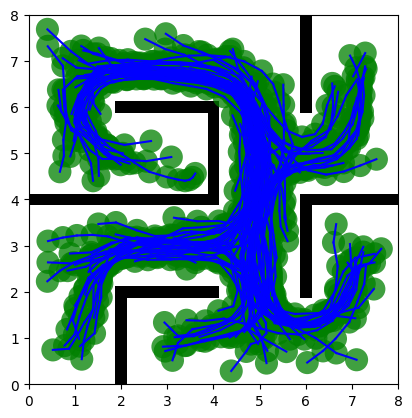

El numero de caminos sin colisión fue de  99


In [74]:
radius = 0.25

CaminosSinColl = []
TiemposSinColl = []


fig, ax = plt.subplots() #caminos desde un punto
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)
hitPos = False
for k in range(100):
    for v in CaminosTest[k]:
        ax.add_patch(Circle((v[0], v[1]), radius, facecolor='green', alpha = 0.75))
        if sampleFree(v[0], v[1], radius) == False: # si no es libre de colision entonces si pega
            hitPos = True
    if hitPos == False: #si no pega con un obstaculo
       CaminosSinColl.append(CaminosTest[k])
       TiemposSinColl.append(Tiempos[k])
    hitPos = False
        #print(k)
    i = 0
    for j in range(len(CaminosTest[k])):
        print(i, end=' \r')
        if j != 0:
            x1 = CaminosTest[k][j][0]
            y1 = CaminosTest[k][j][1]

            padre = CaminosTest[k][j - 1]
            x2 = padre[0]
            y2 = padre[1]

            plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
            i+=1
    

ax.set_aspect('equal')

plt.show()
print("El numero de caminos sin colisión fue de ", len(CaminosSinColl))
#print(len(TiemposSinColl))

In [75]:
print(TiemposSinColl)
sumatime = 0
for i in range(len(TiemposSinColl)):
    sumatime += TiemposSinColl[i]
meantime = sumatime/len(TiemposSinColl)

print("El tiempo promedio fue de ", meantime)

[1.2186496257781982, 1.1717605590820312, 0.4358358383178711, 0.5041911602020264, 0.7744972705841064, 1.0752875804901123, 0.5459983348846436, 0.11920881271362305, 1.8096120357513428, 1.3109230995178223, 0.6595797538757324, 1.2961342334747314, 1.2497525215148926, 0.7628309726715088, 1.3042559623718262, 0.0, 0.4099583625793457, 0.2934441566467285, 1.2407896518707275, 1.3208022117614746, 0.6438324451446533, 1.8279664516448975, 0.7688093185424805, 1.4620921611785889, 0.9324884414672852, 0.924614667892456, 0.4195866584777832, 0.0, 1.4538991451263428, 1.576845645904541, 2.140702486038208, 0.604346513748169, 1.4614126682281494, 1.098398208618164, 1.4081952571868896, 1.8843326568603516, 0.6693181991577148, 0.911278486251831, 0.6205902099609375, 0.7162413597106934, 0.8999686241149902, 1.0996026992797852, 1.0241568088531494, 1.7014234066009521, 1.0890319347381592, 0.0, 0.1208343505859375, 0.3621211051940918, 1.9554994106292725, 0.8478693962097168, 0.8539936542510986, 1.2722558975219727, 1.6468114

In [76]:
DistEuclidea = []

for k in range(len(CaminosSinColl)):
    Dist = 0
    for i in range(len(CaminosSinColl[k])):
        if i != 0:
            Hijo = np.array(CaminosTest[k])
            x1 = CaminosSinColl[k][i][0]
            y1 = CaminosSinColl[k][i][1]

            padre = np.array(CaminosSinColl[k][i - 1])
            x2 = padre[0]
            y2 = padre[1]

            Dist += np.linalg.norm(Hijo - padre)

    DistEuclidea.append(Dist)        

print(DistEuclidea)
print(len(DistEuclidea))

sumadist = 0
for i in range(len(DistEuclidea)):
    sumadist+= DistEuclidea[i]
meandist = sumadist/len(DistEuclidea)
print("El promedio de distancia fue de", meandist)

[223.1488543738721, 235.28644317721904, 21.85390892460596, 31.41717447036072, 101.08222322992758, 208.98605901271966, 38.41760942374447, 0.9130450260121395, 465.40764978207426, 298.46890912920765, 68.31004839766156, 283.35257195116355, 253.05255765643304, 89.73214634362006, 282.49389771297075, 0, 25.24197685614607, 8.78353897906211, 315.71473988954983, 363.46000886951475, 74.82361232535361, 626.3658242326009, 73.16516382662577, 413.88613448590854, 138.9306930612715, 128.70435242545926, 24.943470133721974, 0, 370.75989929820054, 351.7708317277028, 832.0709451793476, 42.146195620295394, 332.76857195614275, 180.17028316631286, 368.4518952516104, 563.8665860092044, 57.44707276816519, 113.86291514225636, 54.34343526254581, 76.6788645059863, 100.60753531935845, 205.63574320209312, 161.72889495546863, 573.6482758296635, 180.05850914436442, 0, 1.9800599340564005, 17.751025331924744, 608.3021239095028, 96.61016609957969, 98.89426963419183, 274.2764868722317, 454.2122349658118, 226.1276103496816

In [52]:
TiemposSinColl = np.array([1.2186496257781982, 1.1717605590820312, 0.4358358383178711, 0.5041911602020264, 0.7744972705841064, 1.0752875804901123, 0.5459983348846436, 0.11920881271362305, 1.8096120357513428, 1.3109230995178223, 0.6595797538757324, 1.2961342334747314, 1.2497525215148926, 0.7628309726715088, 1.3042559623718262, 0.0, 0.4099583625793457, 0.2934441566467285, 1.2407896518707275, 1.3208022117614746, 0.6438324451446533, 1.8279664516448975, 0.7688093185424805, 1.4620921611785889, 0.9324884414672852, 0.924614667892456, 0.4195866584777832, 0.0, 1.4538991451263428, 1.576845645904541, 2.140702486038208, 0.604346513748169, 1.4614126682281494, 1.098398208618164, 1.4081952571868896, 1.8843326568603516, 0.6693181991577148, 0.911278486251831, 0.6205902099609375, 0.7162413597106934, 0.8999686241149902, 1.0996026992797852, 1.0241568088531494, 1.7014234066009521, 1.0890319347381592, 0.0, 0.1208343505859375, 0.3621211051940918, 1.9554994106292725, 0.8478693962097168, 0.8539936542510986, 1.2722558975219727, 1.6468114852905273, 1.2126128673553467, 0.6235320568084717, 0.18401741981506348, 1.6508479118347168, 0.7186789512634277, 0.9959228038787842, 1.0860109329223633, 0.843428373336792, 0.9575061798095703, 0.5512063503265381, 0.9624228477478027, 0.07053279876708984, 1.6410295963287354, 0.7222645282745361, 1.5948097705841064, 0.8554675579071045, 2.9134790897369385, 1.2464628219604492, 0.5002551078796387, 0.6637973785400391, 1.0549604892730713, 1.5352070331573486, 0.7367970943450928, 0.7923550605773926, 1.2120046615600586, 0.8341982364654541, 0.0, 1.4950084686279297, 1.217055082321167, 0.6755204200744629, 0.7178728580474854, 0.11734771728515625, 1.295513391494751, 0.9147076606750488, 1.449855089187622, 1.8249101638793945, 1.6505653858184814, 1.0127387046813965, 0.7077643871307373, 1.1882073879241943, 1.130373477935791, 1.149125576019287, 0.8323380947113037, 1.0000553131103516, 0.7186832427978516, 1.1883337497711182])
meantime = 0.9934122827317979

stdevTime = statistics.stdev(TiemposSinColl,meantime)

print("Promedio Tiempo : ", meantime)
print("Standard Dev Time : ", stdevTime)




DistEuclidea = np.array([223.1488543738721, 235.28644317721904, 21.85390892460596, 31.41717447036072, 101.08222322992758, 208.98605901271966, 38.41760942374447, 0.9130450260121395, 465.40764978207426, 298.46890912920765, 68.31004839766156, 283.35257195116355, 253.05255765643304, 89.73214634362006, 282.49389771297075, 0, 25.24197685614607, 8.78353897906211, 315.71473988954983, 363.46000886951475, 74.82361232535361, 626.3658242326009, 73.16516382662577, 413.88613448590854, 138.9306930612715, 128.70435242545926, 24.943470133721974, 0, 370.75989929820054, 351.7708317277028, 832.0709451793476, 42.146195620295394, 332.76857195614275, 180.17028316631286, 368.4518952516104, 563.8665860092044, 57.44707276816519, 113.86291514225636, 54.34343526254581, 76.6788645059863, 100.60753531935845, 205.63574320209312, 161.72889495546863, 573.6482758296635, 180.05850914436442, 0, 1.9800599340564005, 17.751025331924744, 608.3021239095028, 96.61016609957969, 98.89426963419183, 274.2764868722317, 454.2122349658118, 226.12761034968167, 62.825408486824365, 2.330492259297294, 473.7778136344552, 99.18162015141363, 160.58047531074652, 200.34333178099507, 116.76215370254172, 152.49992413320686, 38.59601953248738, 135.6782216432782, 0.5671226410727375, 475.21586796788546, 69.85030311888976, 407.1638594443836, 121.95447872892994, 679.3558269232188, 273.4805382720871, 28.253572352859706, 67.04537799845698, 141.9971104981337, 349.6967933744581, 71.86920822176002, 91.45394620357064, 216.86134821121368, 98.66609937407924, 0, 336.7650675750313, 213.08455477592867, 69.45465354186202, 80.60064266912663, 1.6009989031169178, 227.64786433900514, 101.85267062540998, 306.76092794995975, 553.1187850464245, 466.7886100251869, 258.83146963506306, 129.6588877389547, 250.76834674447062, 421.27192075739873, 228.59604347638526, 245.1386632627353, 125.86492664514877, 104.97618844088281, 296.89914256914994])
meandist = 202.98788205878776

stdevDist = statistics.stdev(DistEuclidea,meandist)
print(len(DistEuclidea))

print("Promedio Distancia : ", meandist)
print("Standard Dev Distance : ", stdevDist)

Promedio Tiempo :  0.9934122827317979
Standard Dev Time :  0.5226945110605608
99
Promedio Distancia :  202.98788205878776
Standard Dev Distance :  178.91039464372815


# TensorFlow con DropOut 100 PTS

In [77]:
#print(pn)
#print(len(pn))
Tiempos = []

CaminosTest = []

CurrDestX = _100_pts[0][2]
CurrDestY = _100_pts[0][3]

CurrCamino = []
#GoalNode = np.array([_100_pts[0][2] ,_100_pts[0][3]])
#CurrCamino.append(InitialNode) 

#qt = [[InitialNode[0], InitialNode[1], GoalNode[0], GoalNode[1]]]
MAX = 100

for i in range(len(_100_pts)): #checamos cada nodo previo de el conjunto de nuevos nodos q_tplus1
    #if itr == 0:
     # InitialNode = np.array([X_test[k][0],X_test[k][1]])
      #CurrCamino.append(InitialNode)
      start = time.time()

      qt = [[float(_100_pts[i][0]), float(_100_pts[i][1]), _100_pts[i][2], _100_pts[i][3]]]

      InitialNode = np.array([_100_pts[i][0],_100_pts[i][1]])
      GoalNode = np.array([_100_pts[i][2] ,_100_pts[i][3]])
      CurrCamino.append(InitialNode) 

      k = 0
      while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(GoalNode)) >= 0.75 and k < MAX:
        qnext = mlp2.predict(qt)
        qt = [[float(qnext[0][0]), float(qnext[0][1]), GoalNode[0], GoalNode[1]]]
        CurrCamino.append([qnext[0][0],qnext[0][1]])
        k+=1
      
      CaminosTest.append(CurrCamino)

      end = time.time()
      Tiempos.append(end - start)

      CurrCamino = []

#print(len(_100_pts))
#print(len(CaminosTest))
#print(Tiempos)

1/1 [==============================] - 0s 52ms/step


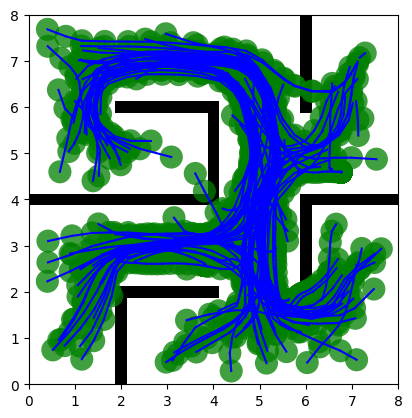

El numero de caminos sin colisión fue de  86
86


In [78]:
radius = 0.25

CaminosSinColl = []
TiemposSinColl = []


fig, ax = plt.subplots() #caminos desde un punto
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)
hitPos = False
for k in range(100):
    for v in CaminosTest[k]:
        ax.add_patch(Circle((v[0], v[1]), radius, facecolor='green', alpha = 0.75))
        if sampleFree(v[0], v[1], radius) == False: # si no es libre de colision entonces si pega
            hitPos = True
    if hitPos == False: #si no pega con un obstaculo
       CaminosSinColl.append(CaminosTest[k])
       TiemposSinColl.append(Tiempos[k])
    hitPos = False
        #print(k)
    i = 0
    for j in range(len(CaminosTest[k])):
        print(i, end=' \r')
        if j != 0:
            x1 = CaminosTest[k][j][0]
            y1 = CaminosTest[k][j][1]

            padre = CaminosTest[k][j - 1]
            x2 = padre[0]
            y2 = padre[1]

            plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
            i+=1
    

ax.set_aspect('equal')

plt.show()
print("El numero de caminos sin colisión fue de ", len(CaminosSinColl))
print(len(TiemposSinColl))

In [79]:
print(TiemposSinColl)
sumatime = 0
for i in range(len(TiemposSinColl)):
    sumatime += TiemposSinColl[i]
meantime = sumatime/len(TiemposSinColl)

print("El tiempo promedio fue de ", meantime)

[1.087324857711792, 1.276172399520874, 0.5732362270355225, 6.2419962882995605, 1.1521368026733398, 0.5955343246459961, 5.782115459442139, 2.0961365699768066, 0.7530136108398438, 1.1103579998016357, 1.0511877536773682, 0.8628056049346924, 1.1611645221710205, 0.0, 0.5180609226226807, 0.28662681579589844, 1.57133150100708, 0.7243597507476807, 2.3814809322357178, 0.785813570022583, 1.6863014698028564, 0.9576969146728516, 0.8574984073638916, 0.5405104160308838, 0.0, 1.7734110355377197, 1.5190494060516357, 6.140341758728027, 1.4846765995025635, 1.9528939723968506, 2.7031145095825195, 3.63165283203125, 1.241180419921875, 1.2369210720062256, 1.2340211868286133, 9.83050274848938, 1.866028070449829, 2.0620832443237305, 1.7895374298095703, 0.0, 0.18073344230651855, 0.6279852390289307, 1.0131783485412598, 2.7145402431488037, 9.372060537338257, 1.1015939712524414, 0.1885972023010254, 2.9788765907287598, 1.377124309539795, 1.9897794723510742, 1.866927146911621, 1.3219151496887207, 1.5818114280700684

In [80]:
DistEuclidea = []

for k in range(len(CaminosSinColl)):
    Dist = 0
    for i in range(len(CaminosSinColl[k])):
        if i != 0:
            Hijo = np.array(CaminosTest[k])
            x1 = CaminosSinColl[k][i][0]
            y1 = CaminosSinColl[k][i][1]

            padre = np.array(CaminosSinColl[k][i - 1])
            x2 = padre[0]
            y2 = padre[1]

            Dist += np.linalg.norm(Hijo - padre)

    DistEuclidea.append(Dist)        

print(DistEuclidea)
print(len(DistEuclidea))


sumadist = 0
for i in range(len(DistEuclidea)):
    sumadist+= DistEuclidea[i]
meandist = sumadist/len(DistEuclidea)
print("El promedio de distancia fue de", meandist)


[179.41763428430392, 258.2246767756263, 19.754739168963027, 629.2854777636619, 351.1393511530692, 229.2469505273323, 1287.4137937113705, 824.9891835563104, 274.0699960846863, 291.1018180702499, 182.8264376155231, 235.2384240775419, 286.98094096794955, 0, 113.0933269440979, 29.261055723420206, 252.4447196150998, 106.168277253656, 669.1218275807876, 220.92667779855609, 320.2926383664125, 365.1039153637252, 101.39343237473594, 163.29218117999451, 0, 375.51173776113563, 176.09077250442803, 395.87460210270245, 385.3126212177628, 272.99815788326885, 743.1846661476005, 376.61112492092957, 135.89923824770622, 137.53165357976943, 208.92758856878876, 2252.7601507744166, 170.0532768331696, 223.21941057725482, 231.56273935489284, 0, 96.45095732214358, 137.93618464006255, 197.68099087818925, 614.1714554717264, 1257.9643661800803, 27.742922527369327, 12.580140162382348, 403.1220729073723, 293.3695109138388, 144.5999613461601, 182.15995568244102, 168.1744640010167, 293.73808551349646, 876.71104868715

In [53]:
TiemposSinColl = np.array([1.087324857711792, 1.276172399520874, 0.5732362270355225, 6.2419962882995605, 1.1521368026733398, 0.5955343246459961, 5.782115459442139, 2.0961365699768066, 0.7530136108398438, 1.1103579998016357, 1.0511877536773682, 0.8628056049346924, 1.1611645221710205, 0.0, 0.5180609226226807, 0.28662681579589844, 1.57133150100708, 0.7243597507476807, 2.3814809322357178, 0.785813570022583, 1.6863014698028564, 0.9576969146728516, 0.8574984073638916, 0.5405104160308838, 0.0, 1.7734110355377197, 1.5190494060516357, 6.140341758728027, 1.4846765995025635, 1.9528939723968506, 2.7031145095825195, 3.63165283203125, 1.241180419921875, 1.2369210720062256, 1.2340211868286133, 9.83050274848938, 1.866028070449829, 2.0620832443237305, 1.7895374298095703, 0.0, 0.18073344230651855, 0.6279852390289307, 1.0131783485412598, 2.7145402431488037, 9.372060537338257, 1.1015939712524414, 0.1885972023010254, 2.9788765907287598, 1.377124309539795, 1.9897794723510742, 1.866927146911621, 1.3219151496887207, 1.5818114280700684, 2.0306499004364014, 0.08799362182617188, 2.935810089111328, 9.798096895217896, 2.775172233581543, 1.2495641708374023, 2.0149707794189453, 0.7574501037597656, 1.0412628650665283, 1.6015467643737793, 3.1948351860046387, 1.503399133682251, 1.1330068111419678, 1.9824953079223633, 1.113356351852417, 0.008044242858886719, 2.7471230030059814, 9.520030975341797, 1.0571084022521973, 1.5060346126556396, 0.1800241470336914, 1.4142560958862305, 1.5022563934326172, 2.399158000946045, 2.6429052352905273, 10.433802604675293, 2.0877723693847656, 1.1611309051513672, 1.7026925086975098, 1.8026270866394043, 1.5017600059509277, 1.3490853309631348, 2.0761637687683105])
meantime = 2.0598254231519477

stdevTime = statistics.stdev(TiemposSinColl,meantime)

print("Promedio Tiempo : ", meantime)
print("Standard Dev Time : ", stdevTime)




DistEuclidea = np.array([179.41763428430392, 258.2246767756263, 19.754739168963027, 629.2854777636619, 351.1393511530692, 229.2469505273323, 1287.4137937113705, 824.9891835563104, 274.0699960846863, 291.1018180702499, 182.8264376155231, 235.2384240775419, 286.98094096794955, 0, 113.0933269440979, 29.261055723420206, 252.4447196150998, 106.168277253656, 669.1218275807876, 220.92667779855609, 320.2926383664125, 365.1039153637252, 101.39343237473594, 163.29218117999451, 0, 375.51173776113563, 176.09077250442803, 395.87460210270245, 385.3126212177628, 272.99815788326885, 743.1846661476005, 376.61112492092957, 135.89923824770622, 137.53165357976943, 208.92758856878876, 2252.7601507744166, 170.0532768331696, 223.21941057725482, 231.56273935489284, 0, 96.45095732214358, 137.93618464006255, 197.68099087818925, 614.1714554717264, 1257.9643661800803, 27.742922527369327, 12.580140162382348, 403.1220729073723, 293.3695109138388, 144.5999613461601, 182.15995568244102, 168.1744640010167, 293.73808551349646, 876.7110486871568, 16.716499259634123, 209.87043938721857, 2341.384987501394, 348.4098123418713, 172.88923353931287, 253.54923094716108, 95.51073656793977, 181.5994317315347, 134.69905600144563, 450.47376592371836, 121.4839472244579, 208.0470381306453, 886.9838318400847, 196.29491285108398, 0, 328.50734869813726, 1642.7846559214756, 93.79287240883491, 118.62966777699621, 53.296981548935605, 305.0129542209992, 126.68134072236262, 235.39483390979197, 397.9522969577558, 1169.7567927289335, 64.34896889279355, 186.64116124315285, 654.3877799257962, 156.40302777282753, 180.55007925108478, 122.40197036641186, 323.27015840829])
meandist = 348.37736217053975

stdevDist = statistics.stdev(DistEuclidea,meandist)
print(len(DistEuclidea))

print("Promedio Distancia : ", meandist)
print("Standard Dev Distance : ", stdevDist)

Promedio Tiempo :  2.0598254231519477
Standard Dev Time :  2.2525051836876018
86
Promedio Distancia :  348.37736217053975
Standard Dev Distance :  427.91487138419063


# Caminos sin colision

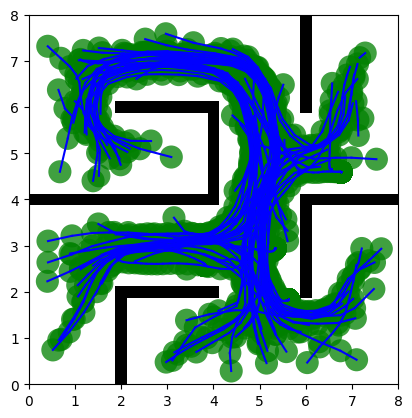

86


In [81]:
radius = 0.25



fig, ax = plt.subplots() #caminos desde un punto
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'black',
             fill=True))


#circle_patch = Circle((1, 8), 0.25, facecolor='blue')
#ax.add_patch(circle_patch)
hitPos = False
for k in range(len(CaminosSinColl)):
    for v in CaminosSinColl[k]:
        ax.add_patch(Circle((v[0], v[1]), radius, facecolor='green', alpha = 0.75))
        
        #print(k)
    i = 0
    for j in range(len(CaminosSinColl[k])):
        print(i, end=' \r')
        if j != 0:
            x1 = CaminosSinColl[k][j][0]
            y1 = CaminosSinColl[k][j][1]

            padre = CaminosSinColl[k][j - 1]
            x2 = padre[0]
            y2 = padre[1]

            plt.plot([x1, x2], [y1, y2], 'b-')  # 'b-' representa líneas azules
            i+=1
    

ax.set_aspect('equal')

plt.show()

print(len(CaminosSinColl))